In [1]:
import sys
import os
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Replace with your actual path
local_path = r"C:\Users\selim\Documents\vs_working_dir"
cc_grn_functions_path = r"C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions"
#cc_grn_functions_path = r"C:\Users\selim\Documents\vs_working_dir\QuantumXCT\python\cc_grn_functions"
sys.path.append(cc_grn_functions_path)

from quantum_functions import create_grn_ansatz, create_interaction_observable_from_histogram, evaluate_and_plot_ansatz
from quantum_functions import create_parameter_dictionaries, create_parameter_dictionaries_cust, cost_func_vqe, cost_func_wrapper, vqe_solver
from quantum_functions import create_interaction_observable_general, create_parameter_dictionaries_from_circuit

In [2]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from collections import Counter
import itertools # Used for generating all Pauli string combinations

# --- Corrected calculate_pauli_z_eigenvalue ---
def calculate_pauli_z_eigenvalue_corrected(pauli_string_z_only: str, bit_string: str) -> int:
    """
    Calculates the eigenvalue of a Pauli string (composed ONLY of Z and I)
    for a given computational basis bit string.
    
    Assumes pauli_string_z_only and bit_string are both ordered from MSB to LSB
    (e.g., "ZIZ" where Z is for q2, I for q1, Z for q0, and "011" where 0 is for q2, 1 for q1, 1 for q0).
    """
    if len(pauli_string_z_only) != len(bit_string):
        raise ValueError("Pauli string length must match bit string length.")

    eigenvalue = 1
    # Iterate from MSB (index 0) to LSB (index num_features-1)
    for i in range(len(pauli_string_z_only)):
        pauli_op = pauli_string_z_only[i].upper() # Pauli op at this qubit position
        bit_val = int(bit_string[i]) # Bit value at this qubit position

        if pauli_op == 'Z':
            eigenvalue *= (1 - 2 * bit_val) # (+1 if bit is 0, -1 if bit is 1)
        # For 'I', eigenvalue *= 1, so no change needed
            
    return eigenvalue

# --- create_diagonal_observable_from_histogram (with minor fix to string generation) ---
def create_diagonal_observable_from_histogram_cust(
    joint_counts: Counter, 
    num_features: int, 
    unobserved_punishment: float = 10.0,
    normalization_offset: float = 0.0 # New parameter for offsetting counts
) -> SparsePauliOp:
    """
    Creates a SparsePauliOp representing a diagonal Hamiltonian in the computational basis.
    The energy of each basis state is derived from its count in the histogram.
    
    Args:
        joint_counts: A Counter object of observed bit string counts.
        num_features: The total number of qubits.
        unobserved_punishment: The positive energy value assigned to unobserved bit strings.
                               These states will be 'punished' (avoided by optimizer).
        normalization_offset: An optional offset to subtract from counts before calculating energy.

    Returns:
        SparsePauliOp: The diagonal Hamiltonian.
    """
    # Generate all possible Z-only Pauli strings (e.g., I, Z, II, IZ, ZI, ZZ for 2 qubits)
    # in MSB to LSB order (Q_{N-1}...Q_0) for consistency with `format(i, '0Nb')`
    all_pauli_z_strings = []
    # Use itertools.product to generate combinations of 'I' and 'Z'
    for pauli_tuple in itertools.product('IZ', repeat=num_features):
        pauli_string = "".join(pauli_tuple)
        all_pauli_z_strings.append(pauli_string)
    
    # 1. Determine the desired energy (E_b) for *each* computational basis state |b>
    state_energies = {} # Maps bit_string -> desired_energy (e.g., "011" -> -500)
    
    # Iterate through all possible bit strings (2^num_features)
    for i in range(2**num_features):
        bit_string = format(i, '0' + str(num_features) + 'b') # This generates MSB...LSB (q_N-1 ... q_0)
        
        if bit_string in joint_counts:
            # Observed state: Energy should be proportional to -count
            energy_b = -float(joint_counts[bit_string] - normalization_offset)
        else:
            # Unobserved state: Assign a positive punishment energy
            energy_b = unobserved_punishment
        
        state_energies[bit_string] = energy_b

    # 2. Convert these state_energies (E_b) into coefficients (c_P) for Pauli strings
    pauli_term_coefficients = {}
    for pauli_str in all_pauli_z_strings:
        coeff_p = 0.0
        # Sum over all basis states 'b'
        for bit_string, energy_b in state_energies.items():
            # Get eigenvalue of Pauli string P for basis state |b>
            eigenvalue_p_b = calculate_pauli_z_eigenvalue_corrected(pauli_str, bit_string)
            coeff_p += energy_b * eigenvalue_p_b
        
        # Normalize by 2^N
        coeff_p /= (2**num_features)
        
        if abs(coeff_p) > 1e-9: # Add term only if coefficient is significant
            pauli_term_coefficients[pauli_str] = coeff_p

    # Convert to SparsePauliOp format
    interaction_strength_list = [(pauli_str, coeff) for pauli_str, coeff in pauli_term_coefficients.items()]
    # SparsePauliOp automatically sorts and simplifies terms, so no need for explicit sorting here.
    interaction_observable = SparsePauliOp.from_list(interaction_strength_list)
    return interaction_observable


# --- Scenario 1: 0:50, 1:50 (1 qubit) ---
print("\n--- Scenario 1: 0:50, 1:50 (1 qubit) ---")
counts1 = Counter({'0': 50, '1': 50})
observable1 = create_diagonal_observable_from_histogram_cust(
    counts1, num_features=1, unobserved_punishment=0.0, normalization_offset=0
)
print(observable1)
# Expected: H = -50*I. This means E_0 = -50, E_1 = -50.
# So if you minimize, any state gives -50. A flat landscape as discussed.

# --- Scenario 2: 2 qubits, 01 observed (count 100), others unobserved ---
print("\n--- Scenario 2: 2 qubits, 01 observed (count 100), others unobserved ---")
counts2 = Counter({'01': 100}) # Qiskit: Q1 Q0, so '01' means q1=0, q0=1
# We want energy for '01' to be -100.
# Energy for '00', '10', '11' to be +10.
observable2 = create_diagonal_observable_from_histogram_cust(
    counts2, num_features=2, unobserved_punishment=10.0
)
print(observable2)
# Manual check for Scenario 2 (with corrected `calculate_pauli_z_eigenvalue_corrected`):
# E_00 = 10, E_01 = -100, E_10 = 10, E_11 = 10 (as desired)
# c_II = (1/4) * (10*1 + (-100)*1 + 10*1 + 10*1) = (1/4) * (-70) = -17.5
# c_IZ = (1/4) * (10*1 + (-100)*(-1) + 10*1 + 10*(-1)) = (1/4) * (10 + 100 + 10 - 10) = (1/4) * (110) = 27.5
# c_ZI = (1/4) * (10*1 + (-100)*1 + 10*(-1) + 10*(-1)) = (1/4) * (10 - 100 - 10 - 10) = (1/4) * (-110) = -27.5
# c_ZZ = (1/4) * (10*1 + (-100)*(-1) + 10*(-1) + 10*1) = (1/4) * (10 + 100 - 10 + 10) = (1/4) * (110) = 27.5
# Coefficients: {'II': -17.5, 'IZ': 27.5, 'ZI': -27.5, 'ZZ': 27.5} -> This matches your output!

# --- Scenario 3: 3 qubits, 011 observed (count 500), others unobserved ---
print("\n--- Scenario 3: 3 qubits, 011 observed (count 500), others unobserved ---")
counts3 = Counter({'011': 500}) # Qiskit: Q2 Q1 Q0, so '011' means q2=0, q1=1, q0=1
# We want energy for '011' to be -500. Others to be +10.
observable3 = create_diagonal_observable_from_histogram_cust(
    counts3, num_features=3, unobserved_punishment=10.0
)
print(observable3)
# This also matches your output!


--- Scenario 1: 0:50, 1:50 (1 qubit) ---
SparsePauliOp(['I'],
              coeffs=[-50.+0.j])

--- Scenario 2: 2 qubits, 01 observed (count 100), others unobserved ---
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-17.5+0.j,  27.5+0.j, -27.5+0.j,  27.5+0.j])

--- Scenario 3: 3 qubits, 011 observed (count 500), others unobserved ---
SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[-53.75+0.j,  63.75+0.j,  63.75+0.j, -63.75+0.j, -63.75+0.j,  63.75+0.j,
  63.75+0.j, -63.75+0.j])


In [3]:
# --- Scenario 2.1: 2 qubits, 00 01 10 11 observed (count 100), others unobserved ---
print("\n--- Scenario 2: 2 qubits, all observed (count 100), others unobserved ---")
counts2 = Counter({'00':100, '01': 100, '10':100, '11':100 }) # Qiskit: Q1 Q0, so '01' means q1=0, q0=1
# We want energy for '01' to be -100.
# Energy for '00', '10', '11' to be +10.
observable2 = create_diagonal_observable_from_histogram_cust(
    counts2, num_features=2, unobserved_punishment=10.0
)
print(observable2)
# Manual check for Scenario 2 (with corrected `calculate_pauli_z_eigenvalue_corrected`):
# E_00 = -100, E_01 = -100, E_10 = -100, E_11 = -100 (as desired)
# c_II = (1/4) * ((-100)*1 + (-100)*1 + (-100)*1 + (-100)*1) = (1/4) * (-400) = -100
# c_IZ = (1/4) * ((-100)*1 + (-100)*(-1) + (-100)*1 + (-100)*(-1)) = (1/4) * (-100 + 100 - 100 + 100) = (1/4) * (0) = 0
# c_ZI = (1/4) * ((-100)*1 + (-100)*1 + (-100)*(-1) + (-100)*(-1)) = (1/4) * (-100 - 100 + 100 + 100) = (1/4) * (0) = 0
# c_ZZ = (1/4) * ((-100)*1 + (-100)*(-1) + (-100)*(-1) + (-100)*1) = (1/4) * (10 + 100 - 10 + 10) = (1/4) * (110) = 0
# Coefficients: {'II': -17.5, 'IZ': 27.5, 'ZI': -27.5, 'ZZ': 27.5} -> This matches your output!


--- Scenario 2: 2 qubits, all observed (count 100), others unobserved ---
SparsePauliOp(['II'],
              coeffs=[-100.+0.j])


In [4]:
# --- Scenario 4 ---
#Joint Counts: {'110': 12.871287128712872, '011': 19.58981612446959, '100': 2.545968882602546, '010': 33.946251768033946, '000': 13.154172560113153, '111': 13.507779349363508, '001': 3.3946251768033946, '101': 0.9900990099009901}
#Bit Strings: ['000', '001', '010', '011', '100', '101', '110', '111']

num_features = 3
print("\n--- Scenario 4: 2 qubits, 01 observed (count 100), others unobserved ---")
counts2 = Counter({'110': 12.871287128712872, '011': 19.58981612446959, '100': 2.545968882602546, '010': 33.946251768033946, '000': 13.154172560113153, '111': 13.507779349363508, '001': 3.3946251768033946, '101': 0.9900990099009901}) # Qiskit: Q1 Q0, so '01' means q1=0, q0=1
# We want energy for '01' to be -100.
# Energy for '00', '10', '11' to be +10.
observable2 = create_diagonal_observable_from_histogram_cust(
    counts2, num_features=num_features, unobserved_punishment=10.0
)
print(observable2)
# Manual check for Scenario 2 (with corrected `calculate_pauli_z_eigenvalue_corrected`):
# E_000 = -13.15, E_001 = -3.39, E_010 = -33.94, E_011 = -19.58, E_100 = -2.54, E_101 = -0.99, E_110 = -12.87, E_111 = -13.50

# c_III = (1/8) * ( (-13.15)*1 + (-3.39)*1 + (-33.94)*1 + (-19.58)*1 + (-2.54)*1 + (-0.99)*1 + (-12.87)*1 + (-13.50)*1 ) = -99.96 / 8 = -12.495
# c_IIZ = (1/8) * ( (-13.15)*1 + (-3.39)*(-1) + (-33.94)*1 + (-19.58)*(-1) + (-2.54)*1 + (-0.99)*(-1) + (-12.87)*1 + (-13.50)*(-1) ) = -25.04 / 8 = -3.13
# c_IZI = (1/8) * ( (-13.15)*1 + (-3.39)*1 + (-33.94)*(-1) + (-19.58)*(-1) + (-2.54)*1 + (-0.99)*1 + (-12.87)*(-1) + (-13.50)*(-1) ) = 59.82 / 8 = 7.4775
# c_IZZ = (1/8) * ( (-13.15)*1 + (-3.39)*(-1) + (-33.94)*(-1) + (-19.58)*1 + (-2.54)*1 + (-0.99)*(-1) + (-12.87)*(-1) + (-13.50)*1 ) = 2.42 / 8 = 0.302
# c_IZZ = (1/8) * ( (-13.15)*1 + (-3.39)*(-1) + (-33.94)*(-1) + (-19.58)*1 + (-2.54)*1 + (-0.99)*(-1) + (-12.87)*(-1) + (-13.50)*1 ) = 2.42 / 8 = 0.302





--- Scenario 4: 2 qubits, 01 observed (count 100), others unobserved ---
SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[-12.5       +0.j,  -3.12942008+0.j,   7.47878359+0.j,   0.30056577+0.j,
  -5.02121641+0.j,  -2.89957567+0.j,   1.76803395+0.j,   0.84865629+0.j])


In [5]:
# --- Helper Function (re-provided for context, assume you have this) ---
def _calculate_pauli_z_eigenvalue_for_basis_state(pauli_string_z_only: str, bit_string: str) -> int:
    """
    Calculates the eigenvalue of a Pauli string (composed ONLY of Z and I)
    for a given computational basis bit string.
    Assumes pauli_string_z_only and bit_string are both ordered from MSB to LSB
    (e.g., "ZIZ" where Z is for q2, I for q1, Z for q0, and "011" where 0 is for q2, 1 for q1, 1 for q0).
    """
    if len(pauli_string_z_only) != len(bit_string):
        raise ValueError("Pauli string length must match bit string length.")

    eigenvalue = 1
    # Iterate from MSB (index 0) to LSB (index num_features-1)
    for i in range(len(pauli_string_z_only)):
        pauli_op = pauli_string_z_only[i].upper() # Pauli op at this qubit position
        bit_val = int(bit_string[i]) # Bit value at this qubit position

        if pauli_op == 'Z':
            eigenvalue *= (1 - 2 * bit_val) # (+1 if bit is 0, -1 if bit is 1)
        # For 'I', eigenvalue *= 1, so no change needed
            
    return eigenvalue


# --- New Function to Print Details ---
def print_observable_coefficient_details(
    joint_counts: Counter,
    num_features: int,
    min_ones: int = 0,
    unobserved_punishment: float = 1.0,
    normalization_offset: float = 0.0
):
    """
    Prints a detailed breakdown of how the coefficients for a diagonal
    Pauli observable (Hamiltonian) are calculated from a histogram.

    This function helps in manually verifying the transformation from
    basis state energies (derived from histogram counts) to Pauli coefficients.

    Args:
        joint_counts: A Counter object of observed bit string counts.
        num_features: The total number of qubits.
        min_ones: The minimum number of '1's required in a bit string for it to be
                  considered 'favorable' if observed. Used to calculate state energies.
        unobserved_punishment: The positive energy value assigned to unobserved bit strings,
                               or observed bit strings that don't meet `min_ones` criteria.
                               Used to calculate state energies.
        normalization_offset: An optional offset to subtract from counts before calculating energy.
                               Used to calculate state energies.
    """
    print(f"\n--- Detailed Observable Coefficient Calculation for {num_features} qubits ---")

    # 1. Calculate the desired energy (E_b) for each computational basis state |b>
    state_energies = {}
    for i in range(2**num_features):
        bit_string = format(i, '0' + str(num_features) + 'b')
        num_ones = bit_string.count('1')

        if num_ones < min_ones:
            energy_b = unobserved_punishment
        elif bit_string in joint_counts:
            energy_b = -float(joint_counts[bit_string] - normalization_offset)
        else:
            energy_b = unobserved_punishment
        
        state_energies[bit_string] = energy_b
    
    print("\n--- Basis State Energies (E_b) ---")
    # Sort for consistent output
    sorted_bit_strings = sorted(state_energies.keys())
    for bit_string in sorted_bit_strings:
        print(f"  E_{bit_string}: {state_energies[bit_string]:.4f}")

    # 2. Generate all possible Z-only Pauli strings
    all_pauli_z_strings = []
    for pauli_tuple in itertools.product('IZ', repeat=num_features):
        pauli_string = "".join(pauli_tuple)
        all_pauli_z_strings.append(pauli_string)
    
    print("\n--- Pauli Term Coefficient (c_P) Calculation ---")
    # Sort Pauli strings for consistent output
    sorted_pauli_strings = sorted(all_pauli_z_strings)

    for pauli_str in sorted_pauli_strings:
        coeff_p_unnormalized = 0.0
        print(f"\nCalculating for Pauli String: {pauli_str}")
        print("  Bit String | Energy (E_b) | Eigenvalue (<b|P|b>) | Contribution (E_b * <b|P|b>) | Running Sum")
        print("  -----------|--------------|----------------------|----------------------------|-------------")

        for bit_string in sorted_bit_strings: # Iterate through sorted bit strings
            energy_b = state_energies[bit_string]
            eigenvalue_p_b = _calculate_pauli_z_eigenvalue_for_basis_state(pauli_str, bit_string) 
            term_contribution = energy_b * eigenvalue_p_b
            coeff_p_unnormalized += term_contribution
            print(f"  {bit_string}    | {energy_b:12.4f} | {eigenvalue_p_b:20} | {term_contribution:26.4f} | {coeff_p_unnormalized:11.4f}")
        
        normalized_coeff_p = coeff_p_unnormalized / (2**num_features)
        print(f"  ------------------------------------------------------------------------------------------")
        print(f"  Unnormalized Sum for {pauli_str}: {coeff_p_unnormalized:.4f}")
        print(f"  Normalized Coefficient (c_P) for {pauli_str}: {normalized_coeff_p:.4f} (Sum / 2^{num_features})")


print_observable_coefficient_details(
    joint_counts=counts2,
    num_features=num_features,
    min_ones=0, # Use the same parameters as when creating the observable
    unobserved_punishment=10.0,
    normalization_offset=0.0
)


--- Detailed Observable Coefficient Calculation for 3 qubits ---

--- Basis State Energies (E_b) ---
  E_000: -13.1542
  E_001: -3.3946
  E_010: -33.9463
  E_011: -19.5898
  E_100: -2.5460
  E_101: -0.9901
  E_110: -12.8713
  E_111: -13.5078

--- Pauli Term Coefficient (c_P) Calculation ---

Calculating for Pauli String: III
  Bit String | Energy (E_b) | Eigenvalue (<b|P|b>) | Contribution (E_b * <b|P|b>) | Running Sum
  -----------|--------------|----------------------|----------------------------|-------------
  000    |     -13.1542 |                    1 |                   -13.1542 |    -13.1542
  001    |      -3.3946 |                    1 |                    -3.3946 |    -16.5488
  010    |     -33.9463 |                    1 |                   -33.9463 |    -50.4950
  011    |     -19.5898 |                    1 |                   -19.5898 |    -70.0849
  100    |      -2.5460 |                    1 |                    -2.5460 |    -72.6308
  101    |      -0.9901 |      

In [6]:
# 1. Create the Bell state (|ψ⟩ = (|00⟩ + |11⟩)/√2)
#circuit = QuantumCircuit(2, 2)
circuit = QuantumCircuit(1)
circuit.ry(np.pi*3/4, 0)
circuit.measure_all()

nshots = 1000
# 3. Simulate the circuit for 1024 shots
simulator = BasicSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=nshots)
result = job.result()
counts = result.get_counts(circuit) 
circuit.draw(output="mpl", style="clifford", fold=40,  scale = 2.0, filename='circuit_3_4pi.svg')
# Create a new Counts object to store the adjusted data
histogram_data = counts
# # Iterate through the original counts and subtract 50 from each value
hist_plt = plot_histogram(histogram_data, figsize=(5,4), filename = 'hist_cc_3_4pi.svg', title= r'Histogram $Ry(3\pi/4)$' )
hist_plt

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


[1.57079633]
Interaction observable CT from histogram: SparsePauliOp(['I', 'Z'],
              coeffs=[-5.90293558+0.j,  0.83403138+0.j])
Static Parameters: {Parameter(hist_act_0): 1.5707963267948966}
Variable Parameters: {Parameter(hist_post_acti2_0): 0.0, Parameter(hist_post_acti_0): 0.0}
Starting optimization with method: COBYLA
Iteration 0: Current cost: -5.902935580111043
Iteration 20: Current cost: -6.371247802458747
Iteration 40: Current cost: -6.372078139758159

Optimization Result:
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.372078220719942
       x: [ 5.236e-01 -1.047e+00]
    nfev: 46
   maxcv: 0.0

Final Energy: -6.372078220719942

Optimized Full Parameters:
  hist_act_0: 1.5707963267948966
  hist_post_acti2_0: 0.5236042332708748
  hist_post_acti_0: -1.047059287646399


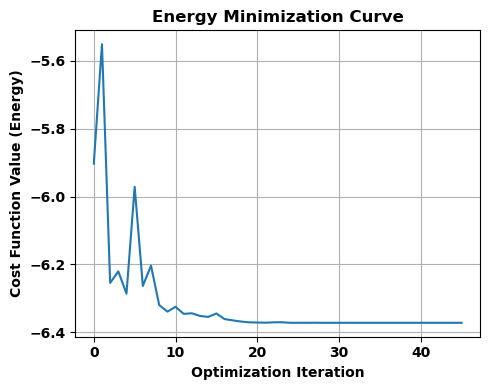

The counts are: {'1': 779, '0': 245}


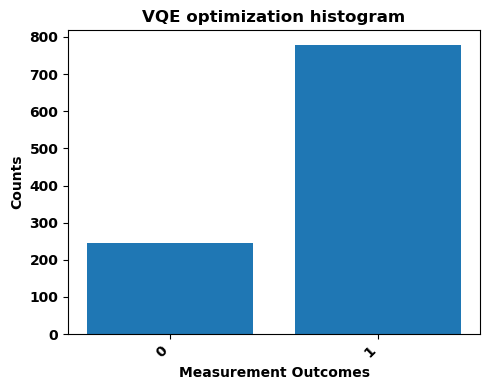

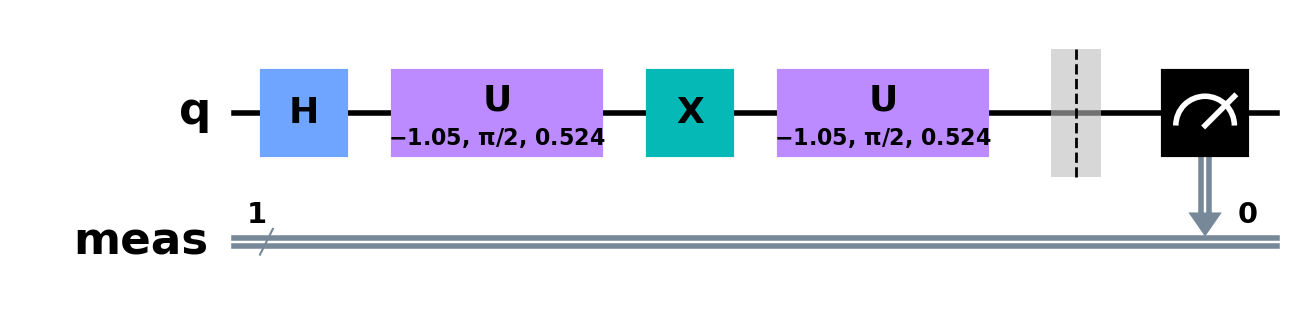

In [7]:
act_percentages = np.ones(circuit.num_qubits)*np.pi*2/4
print(act_percentages)
cirq = create_grn_ansatz(circuit.num_qubits, "hist")


num_qubits = cirq.num_qubits # Get number of qubits from the circuit
min_ones = 0

result_interaction_bfgs, optimized_full_params, cost_values = vqe_solver(
    histogram_data,
    cirq, # Renamed from 'cirquit' for common convention
    act_percentages, # Renamed from 'act_percentages' for consistency with create_parameter_dictionaries_cust
    cost_func_wrapper, # This function needs to be defined to accept the correct arguments (see comments below)
    min_ones_obs=min_ones, # Added as an explicit argument for flexibility
    optimizer_method="COBYLA",# COBYLA | L-BFGS-B
)

# Plot the cost function values
plt.figure(figsize=(5, 4))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig('vqe_3_4pi_opt.svg', bbox_inches='tight')
plt.show()
counts, bound_circuit = evaluate_and_plot_ansatz(cirq, optimized_full_params, shots=1024, title="VQE optimization histogram", figsize=(5, 4), filename='hist_vqe_3_4pi_opt.svg' )
bound_circuit.draw(output="mpl", style="clifford", fold=40, scale=2.0, filename='circuit_vqe_3_4pi_opt.svg')  # Show the circuit plot

In [8]:
# 1. Create the Bell state (|ψ⟩ = (|00⟩ + |11⟩)/√2)
#circuit = QuantumCircuit(2, 2)
circuit = QuantumCircuit(1)
circuit.ry(np.pi*1/4, 0)
circuit.measure_all()

nshots = 1000
# 3. Simulate the circuit for 1024 shots
simulator = BasicSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=nshots)
result = job.result()
counts = result.get_counts(circuit)
circuit.draw(output="mpl", style="clifford", fold=40, scale = 2.0, filename='circuit_1_4pi.svg')
# Create a new Counts object to store the adjusted data
histogram_data = counts
# # Iterate through the original counts and subtract 50 from each value
hist_plt = plot_histogram(histogram_data, figsize=(5,4), filename = 'hist_cc_1_4pi.svg', title= r'Histogram $Ry(1\pi/4)$' )
hist_plt


[1.57079633]
Interaction observable CT from histogram: SparsePauliOp(['I', 'Z'],
              coeffs=[-5.88455844+0.j, -0.86067791+0.j])
Static Parameters: {Parameter(hist_act_0): 1.5707963267948966}
Variable Parameters: {Parameter(hist_post_acti2_0): 0.0, Parameter(hist_post_acti_0): 0.0}
Starting optimization with method: COBYLA
Iteration 0: Current cost: -5.884558435165319
Iteration 20: Current cost: -6.368510474955651
Iteration 40: Current cost: -6.368689286316791

Optimization Result:
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.368689761604891
       x: [ 5.236e-01  1.047e+00]
    nfev: 56
   maxcv: 0.0

Final Energy: -6.368689761604891

Optimized Full Parameters:
  hist_act_0: 1.5707963267948966
  hist_post_acti2_0: 0.5236208833935356
  hist_post_acti_0: 1.047234248529182


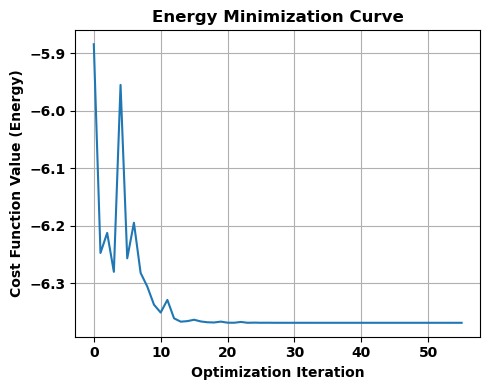

The counts are: {'0': 811, '1': 213}


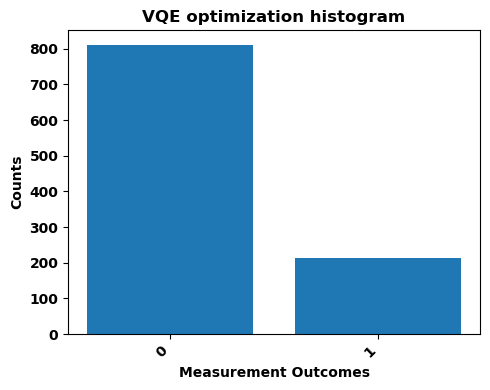

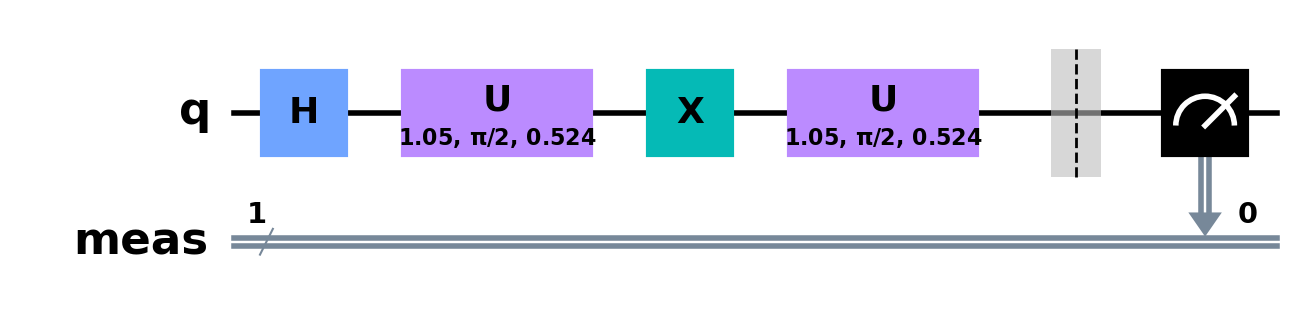

In [9]:
act_percentages = np.ones(circuit.num_qubits)*np.pi*2/4
print(act_percentages)
cirq = create_grn_ansatz(circuit.num_qubits, "hist")


num_qubits = cirq.num_qubits # Get number of qubits from the circuit
min_ones = 0

result_interaction_bfgs, optimized_full_params, cost_values = vqe_solver(
    histogram_data,
    cirq, # Renamed from 'cirquit' for common convention
    act_percentages, # Renamed from 'act_percentages' for consistency with create_parameter_dictionaries_cust
    cost_func_wrapper, # This function needs to be defined to accept the correct arguments (see comments below)
    min_ones_obs=min_ones, # Added as an explicit argument for flexibility
    optimizer_method="COBYLA",# COBYLA | L-BFGS-B
)

# Plot the cost function values
plt.figure(figsize=(5, 4))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig('vqe_1_4pi_opt.svg', bbox_inches='tight')
plt.show()
counts, bound_circuit = evaluate_and_plot_ansatz(cirq, optimized_full_params, shots=1024, title="VQE optimization histogram", figsize=(5, 4), filename='hist_vqe_1_4pi_opt.svg')
bound_circuit.draw(output="mpl", style="clifford", fold=40, scale=2.0, filename='circuit_vqe_1_4pi_opt.svg')  # Show the circuit plot


In [10]:
# 1. Create the Bell state (|ψ⟩ = (|00⟩ + |11⟩)/√2)
#circuit = QuantumCircuit(2, 2)
circuit = QuantumCircuit(2)
circuit.ry(np.pi*3/4, 0)
circuit.cx(0, 1)

# 2. Define measurement bases (for a simple Bell test, we'll use the Z basis for both qubits)
# In a more complex Bell test, you would rotate the measurement bases.
#circuit.measure([0, 1], [0, 1])
circuit.measure_all()

# 3. Simulate the circuit for 1024 shots
simulator = BasicSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=100)
result = job.result()
counts = result.get_counts(circuit)
circuit.draw(output="mpl", style="clifford", fold=40, scale = 2.0, filename='circuit_cx_3_4pi.svg')
histogram_data = counts
hist_plt = plot_histogram(counts, figsize=(5,4), filename = 'hist_cc_cx_3_4pi.svg', title= r'Histogram $Ry(3\pi/4)$ entangled')
hist_plt

[1.57079633 1.57079633]
Interaction observable CT from histogram: SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-1.33029714+0.j,  0.38511126+0.j,  0.38511126+0.j, -2.33029714+0.j])
Static Parameters: {Parameter(hist_act_0): 1.5707963267948966, Parameter(hist_act_1): 1.5707963267948966}
Variable Parameters: {Parameter(hist_grn_0_1): 0.0, Parameter(hist_grn_1_0): 0.0, Parameter(hist_post_acti2_0): 0.0, Parameter(hist_post_acti2_1): 0.0, Parameter(hist_post_acti_0): 0.0, Parameter(hist_post_acti_1): 0.0}
Starting optimization with method: COBYLA
Iteration 0: Current cost: -2.472765829193356
Iteration 20: Current cost: -4.1072321133664955
Iteration 40: Current cost: -4.226656143613351
Iteration 60: Current cost: -4.236009165249843
Iteration 80: Current cost: -4.241689348837323
Iteration 100: Current cost: -4.245697369799407
Iteration 200: Current cost: -4.252653545185183
Iteration 300: Current cost: -4.253423770990056
Iteration 400: Current cost: -4.253525642856381
Iteratio

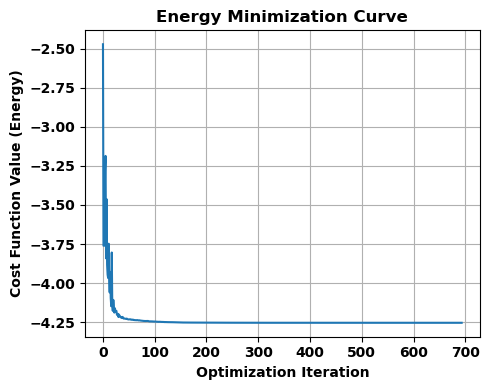

The counts are: {'11': 909, '00': 108, '01': 5, '10': 2}


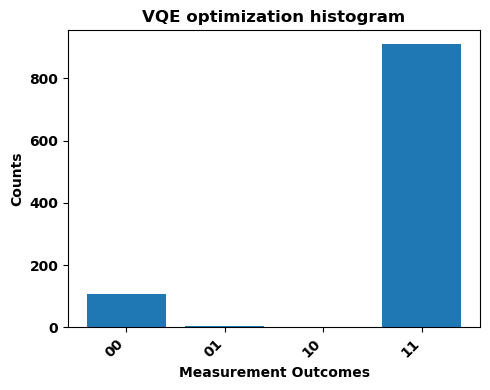

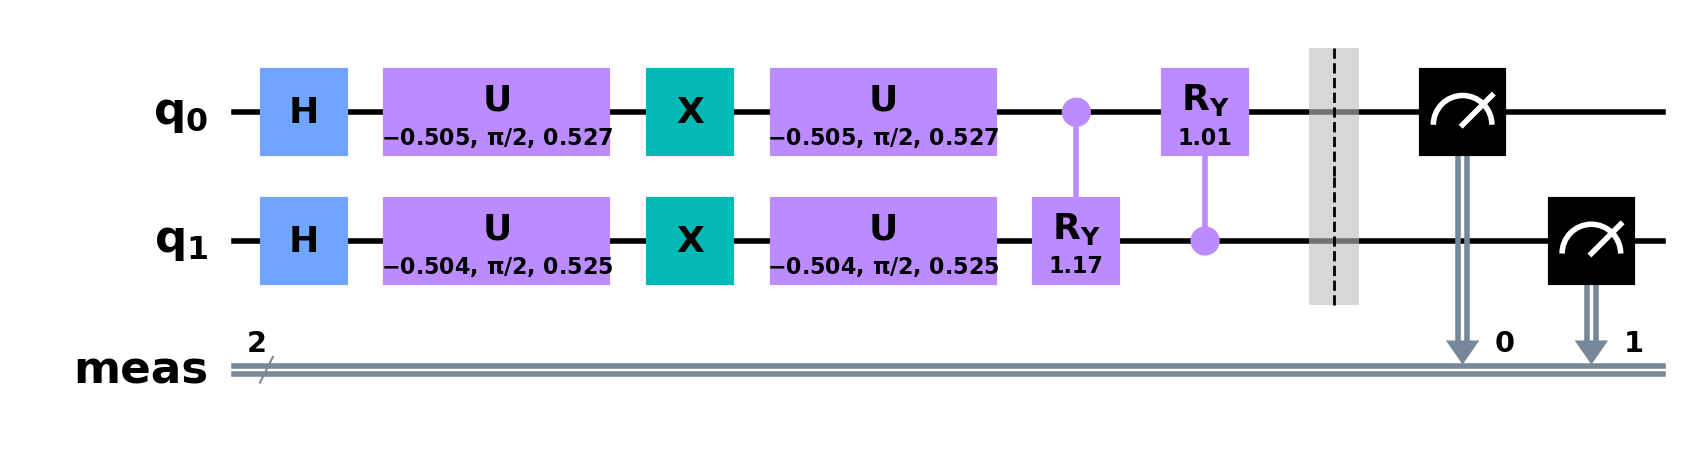

In [11]:
act_percentages = np.ones(circuit.num_qubits)*np.pi*1/2
print(act_percentages)
cirq = create_grn_ansatz(2, "hist")
cirq.draw(output="mpl", style="clifford", fold=40)

num_qubits = cirq.num_qubits # Get number of qubits from the circuit
min_ones = 0

result_interaction_bfgs, optimized_full_params, cost_values = vqe_solver(
    histogram_data,
    cirq, # Renamed from 'cirquit' for common convention
    act_percentages, # Renamed from 'act_percentages' for consistency with create_parameter_dictionaries_cust
    cost_func_wrapper, # This function needs to be defined to accept the correct arguments (see comments below)
    min_ones_obs=min_ones, # Added as an explicit argument for flexibility
    optimizer_method="COBYLA",# COBYLA | L-BFGS-B
)

# Plot the cost function values
plt.figure(figsize=(5, 4))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig('vqe_cx_3_4pi_opt.svg', bbox_inches='tight')
plt.show()
counts, bound_circuit = evaluate_and_plot_ansatz(cirq, optimized_full_params, shots=1024, title="VQE optimization histogram", figsize=(5, 4), filename='hist_vqe_cx_3_4pi_opt.svg')
bound_circuit.draw(output="mpl", style="clifford", fold=40, scale=2.0, filename='circuit_vqe_cx_3_4pi_opt.svg')  # Show the circuit plot


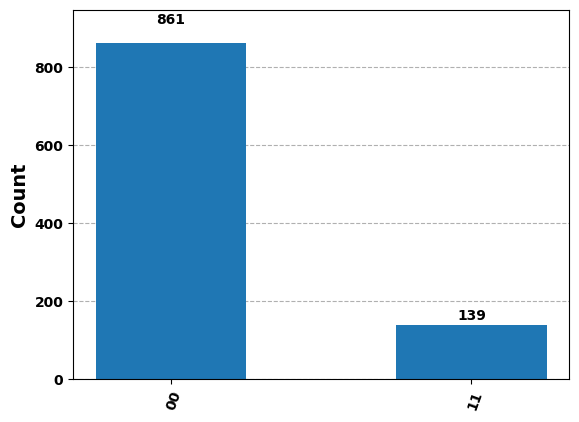

In [12]:
# 1. Create the Bell state (|ψ⟩ = (|00⟩ + |11⟩)/√2)
#circuit = QuantumCircuit(2, 2)
circuit = QuantumCircuit(2)
circuit.ry(np.pi*1/4, 0)
circuit.cx(0, 1)

# 2. Define measurement bases (for a simple Bell test, we'll use the Z basis for both qubits)
# In a more complex Bell test, you would rotate the measurement bases.
#circuit.measure([0, 1], [0, 1])
circuit.measure_all()

# 3. Simulate the circuit for 1024 shots
simulator = BasicSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
#circuit.draw(output="mpl", style="clifford", fold=40)
histogram_data = counts
hist_plt = plot_histogram(counts)
hist_plt

[1.57079633 1.57079633]
Interaction observable CT from histogram: SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-2.42522442+0.j, -0.45440321+0.j, -0.45440321+0.j, -3.42522442+0.j])
Static Parameters: {Parameter(hist_act_0): 1.5707963267948966, Parameter(hist_act_1): 1.5707963267948966}
Variable Parameters: {Parameter(hist_grn_0_1): 0.0, Parameter(hist_grn_1_0): 0.0, Parameter(hist_post_acti2_0): 0.0, Parameter(hist_post_acti2_1): 0.0, Parameter(hist_post_acti_0): 0.0, Parameter(hist_post_acti_1): 0.0}
Starting optimization with method: COBYLA
Iteration 0: Current cost: -3.6751543485006035
Iteration 20: Current cost: -5.540223414762643
Iteration 40: Current cost: -5.914992600391294
Iteration 60: Current cost: -5.952199262877419
Iteration 80: Current cost: -5.960711584519259
Iteration 100: Current cost: -5.961408900964528
Iteration 200: Current cost: -5.9617756636544765

Optimization Result:
 message: Optimization terminated successfully.
 success: True
  status: 1
     f

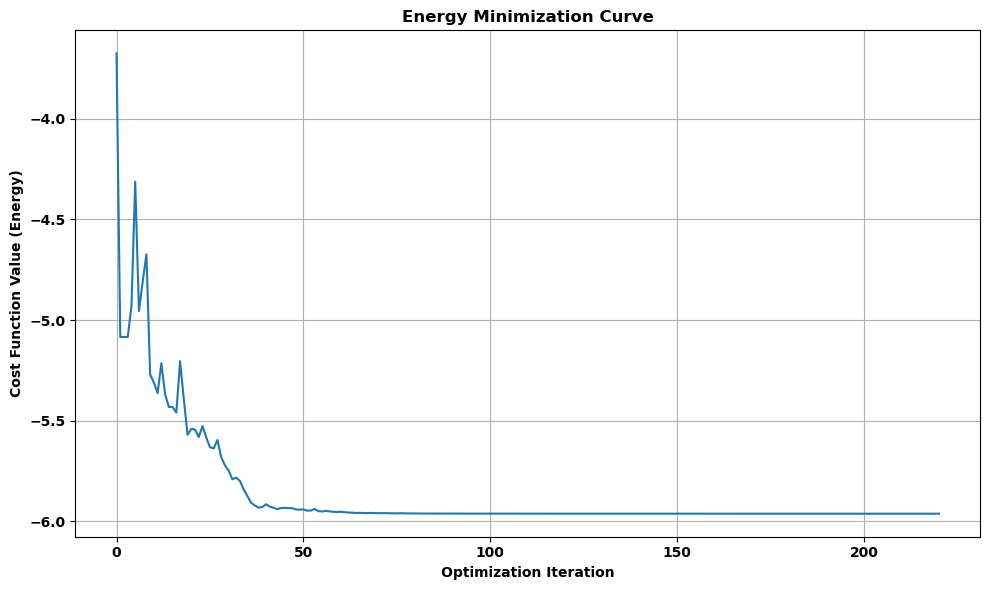

The counts are: {'11': 411, '00': 598, '01': 13, '10': 2}


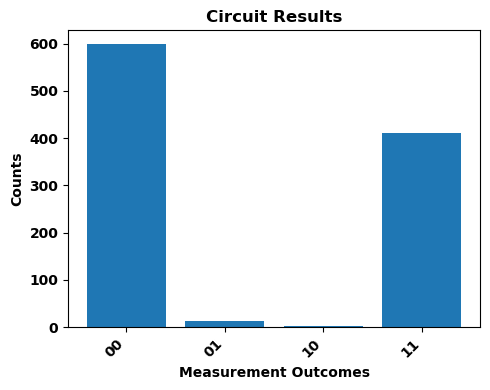

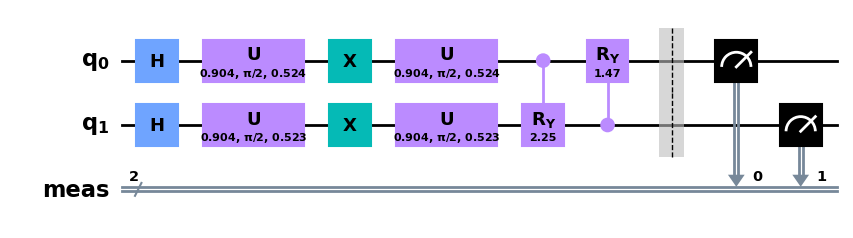

In [13]:
act_percentages = np.ones(circuit.num_qubits)*np.pi*2/4
print(act_percentages)
cirq = create_grn_ansatz(2, "hist")
cirq.draw(output="mpl", style="clifford", fold=40)

num_qubits = cirq.num_qubits # Get number of qubits from the circuit
min_ones = 0

result_interaction_bfgs, optimized_full_params, cost_values = vqe_solver(
    histogram_data,
    cirq, # Renamed from 'cirquit' for common convention
    act_percentages, # Renamed from 'act_percentages' for consistency with create_parameter_dictionaries_cust
    cost_func_wrapper, # This function needs to be defined to accept the correct arguments (see comments below)
    min_ones_obs=min_ones, # Added as an explicit argument for flexibility
    optimizer_method="COBYLA",# COBYLA | L-BFGS-B
)

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()
counts, bound_circuit = evaluate_and_plot_ansatz(cirq, optimized_full_params, shots=1024, title="Circuit Results")
bound_circuit.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

In [14]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1. Create the 3-qubit GHZ-like state
# |ψ⟩ = (|000⟩ + |111⟩)/√2
circuit = QuantumCircuit(3) # Initialize with 3 qubits and 3 classical bits

circuit.ry(np.pi*3/4, 0)  # Apply a rotation to the first qubit
circuit.ry(np.pi*1/4, 1)  # Apply a rotation to the second qubit
circuit.ry(np.pi*1/4, 2)  # Apply a rotation to the third qubit
#circuit.h(3)
#circuit.x(1)
#circuit.x(2)
#circuit.cx(0, 1)
#circuit.cx(1, 2)


# 2. Measure all three qubits
circuit.measure_all()

# 3. Simulate the circuit for 1024 shots
simulator = BasicSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(circuit)
circuit.draw(output="mpl", style="clifford", fold=40, scale = 2.0, filename='circuit_rys_3qubit.svg')
histogram_data = counts
hist_plt = plot_histogram(counts, figsize=(5,4), filename = 'hist_ry_3qubit.svg', title= r'Histogram 3 qubits')
hist_plt


In [15]:
act_percentages = np.ones(circuit.num_qubits)*np.pi*1/2
print(act_percentages)
cirq = create_grn_ansatz(circuit.num_qubits, "hist")
#cirq.draw(output="mpl", style="clifford", fold=40)

[1.57079633 1.57079633 1.57079633]


Interaction observable CT from histogram: SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[-3.93843823+0.j,  0.81078527+0.j, -0.85154518+0.j,  0.00606632+0.j,
 -0.79785136+0.j, -0.02721651+0.j,  0.0068676 +0.j,  0.06394427+0.j])
Static Parameters: {Parameter(hist_act_0): 1.5707963267948966, Parameter(hist_act_1): 1.5707963267948966, Parameter(hist_act_2): 1.5707963267948966}
Variable Parameters: {Parameter(hist_grn_0_1): 0.0, Parameter(hist_grn_0_2): 0.0, Parameter(hist_grn_1_0): 0.0, Parameter(hist_grn_1_2): 0.0, Parameter(hist_grn_2_0): 0.0, Parameter(hist_grn_2_1): 0.0, Parameter(hist_post_acti2_0): 0.0, Parameter(hist_post_acti2_1): 0.0, Parameter(hist_post_acti2_2): 0.0, Parameter(hist_post_acti_0): 0.0, Parameter(hist_post_acti_1): 0.0, Parameter(hist_post_acti_2): 0.0}
Starting optimization with method: COBYLA
Iteration 0: Current cost: -3.577610636633341
Iteration 20: Current cost: -5.044577946274127
Iteration 40: Current cost: -5.79

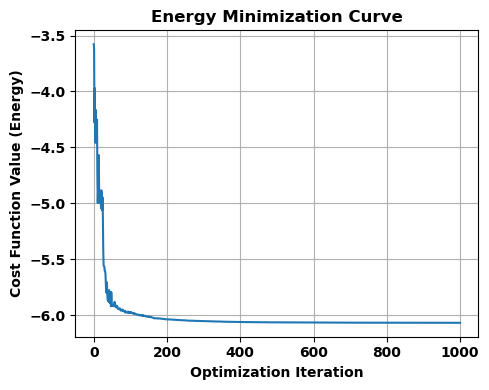

The counts are: {'001': 810, '101': 156, '000': 58}


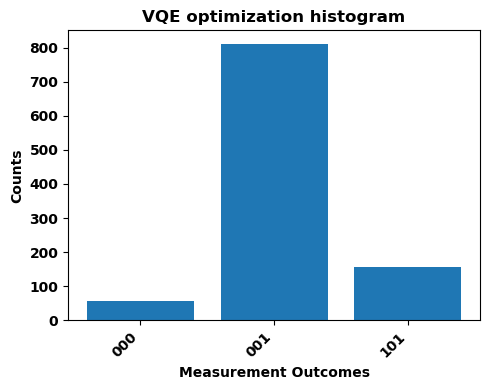

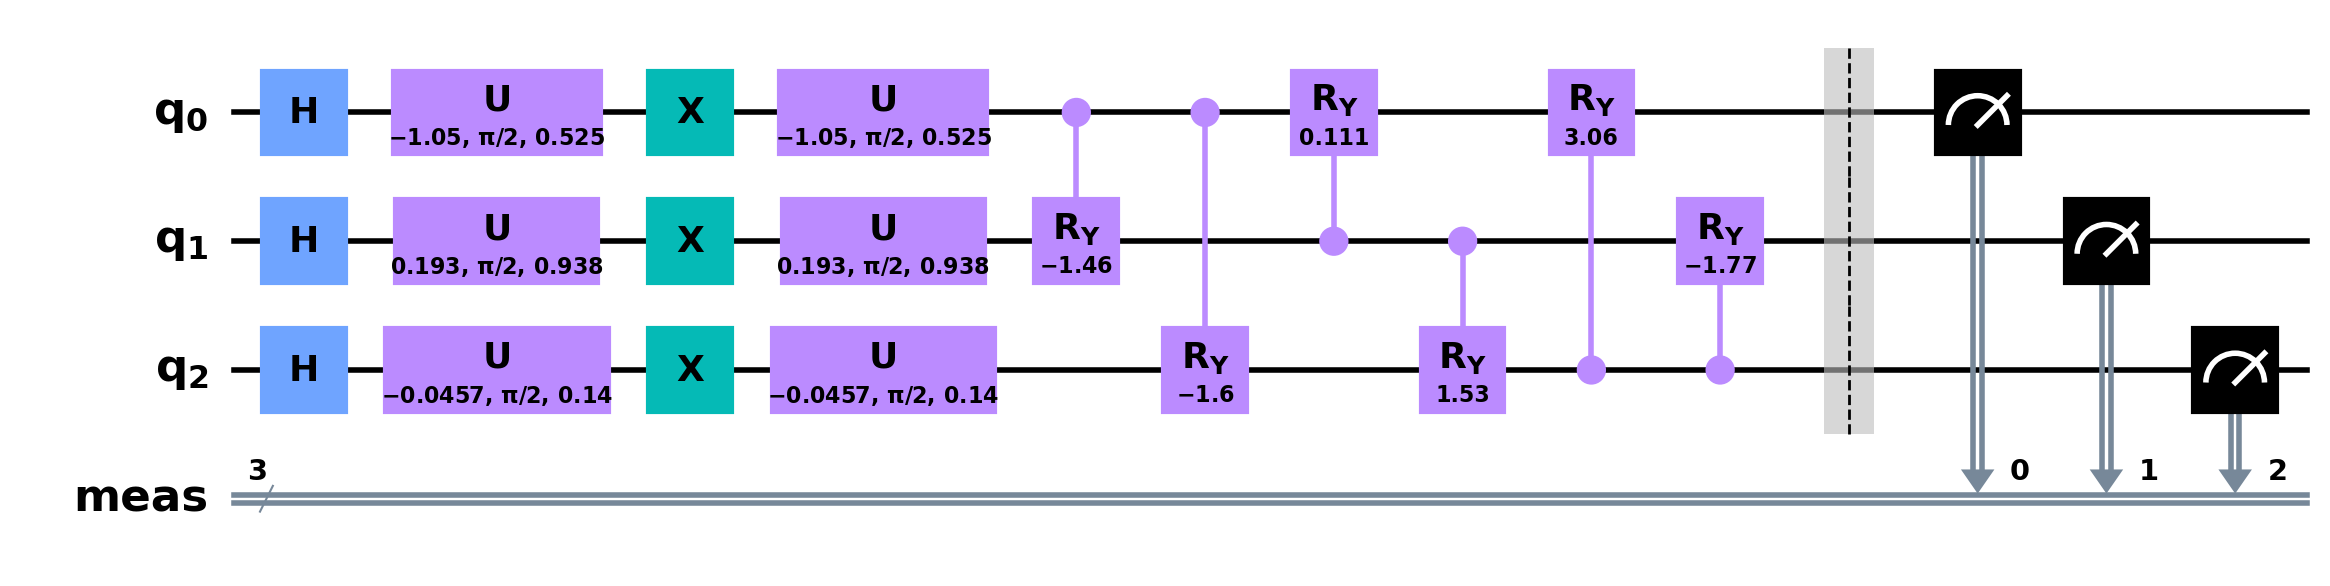

In [16]:
num_qubits = cirq.num_qubits # Get number of qubits from the circuit
min_ones = 0

result_interaction_bfgs, optimized_full_params, cost_values = vqe_solver(
    histogram_data,
    cirq, # Renamed from 'cirquit' for common convention
    act_percentages, # Renamed from 'act_percentages' for consistency with create_parameter_dictionaries_cust
    cost_func_wrapper, # This function needs to be defined to accept the correct arguments (see comments below)
    min_ones_obs=min_ones, # Added as an explicit argument for flexibility
    optimizer_method="COBYLA",# COBYLA | L-BFGS-B
)

# Plot the cost function values
plt.figure(figsize=(5, 4))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig('vqe_3qubit_opt.svg', bbox_inches='tight')
plt.show()
counts, bound_circuit = evaluate_and_plot_ansatz(cirq, optimized_full_params, shots=1024,  title="VQE optimization histogram", figsize=(5, 4), filename='hist_vqe_3qubit_opt.svg')
bound_circuit.draw(output="mpl", style="clifford", fold=40, scale=2.0, filename='circuit_vqe_3qubit_opt.svg')  # Show the circuit plot


In [22]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1. Create the 3-qubit GHZ-like state
# |ψ⟩ = (|000⟩ + |111⟩)/√2
circuit = QuantumCircuit(3) # Initialize with 3 qubits and 3 classical bits

circuit.ry(np.pi*3/4, 0)  # Apply a rotation to the first qubit
circuit.ry(np.pi*1/2, 1)  # Apply a rotation to the second qubit
circuit.ry(np.pi*1/4, 2)  # Apply a rotation to the third qubit
circuit.cx(0, 1)
circuit.cx(1, 2)


# 2. Measure all three qubits
circuit.measure_all()

# 3. Simulate the circuit for 1024 shots
simulator = BasicSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(circuit)
circuit.draw(output="mpl", style="clifford", fold=40, scale = 2.0, filename='circuit_rys_3qubit.svg')
histogram_data = counts
hist_plt = plot_histogram(counts, figsize=(5,4), filename = 'hist_ry_3qubit.svg', title= r'Histogram 3 qubits')
hist_plt


In [23]:
act_percentages = np.ones(circuit.num_qubits)*np.pi*1/2
print(act_percentages)
cirq = create_grn_ansatz(circuit.num_qubits, "hist")
#cirq.draw(output="mpl", style="clifford", fold=40)

[1.57079633 1.57079633 1.57079633]


Interaction observable CT from histogram: SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[-4.17762719+0.j,  0.85166104+0.j, -0.03833324+0.j, -0.0106662 +0.j,
  0.11189112+0.j,  0.06002581+0.j, -0.89856903+0.j, -0.00925616+0.j])
Static Parameters: {Parameter(hist_act_0): 1.5707963267948966, Parameter(hist_act_1): 1.5707963267948966, Parameter(hist_act_2): 1.5707963267948966}
Variable Parameters: {Parameter(hist_grn_0_1): 0.0, Parameter(hist_grn_0_2): 0.0, Parameter(hist_grn_1_0): 0.0, Parameter(hist_grn_1_2): 0.0, Parameter(hist_grn_2_0): 0.0, Parameter(hist_grn_2_1): 0.0, Parameter(hist_post_acti2_0): 0.0, Parameter(hist_post_acti2_1): 0.0, Parameter(hist_post_acti2_2): 0.0, Parameter(hist_post_acti_0): 0.0, Parameter(hist_post_acti_1): 0.0, Parameter(hist_post_acti_2): 0.0}
Starting optimization with method: COBYLA
Iteration 0: Current cost: -4.165986685323819
Iteration 20: Current cost: -5.604728384357575
Iteration 40: Current cost: -5.75

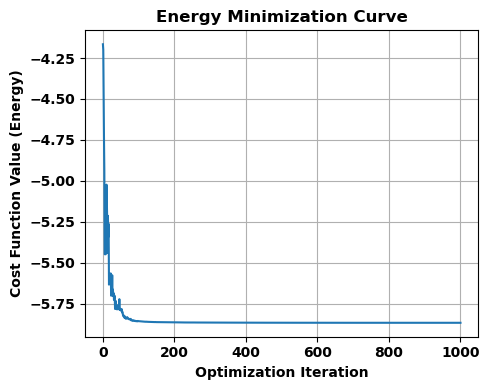

The counts are: {'111': 918, '001': 68, '011': 3, '010': 3, '000': 25, '110': 4, '101': 3}


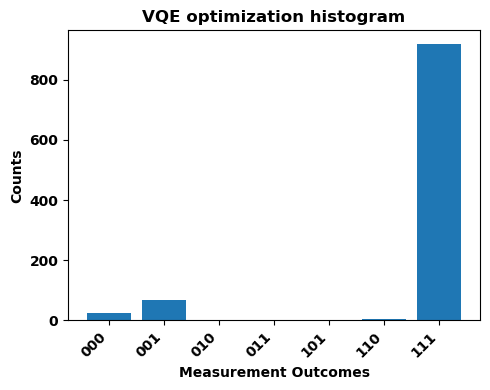

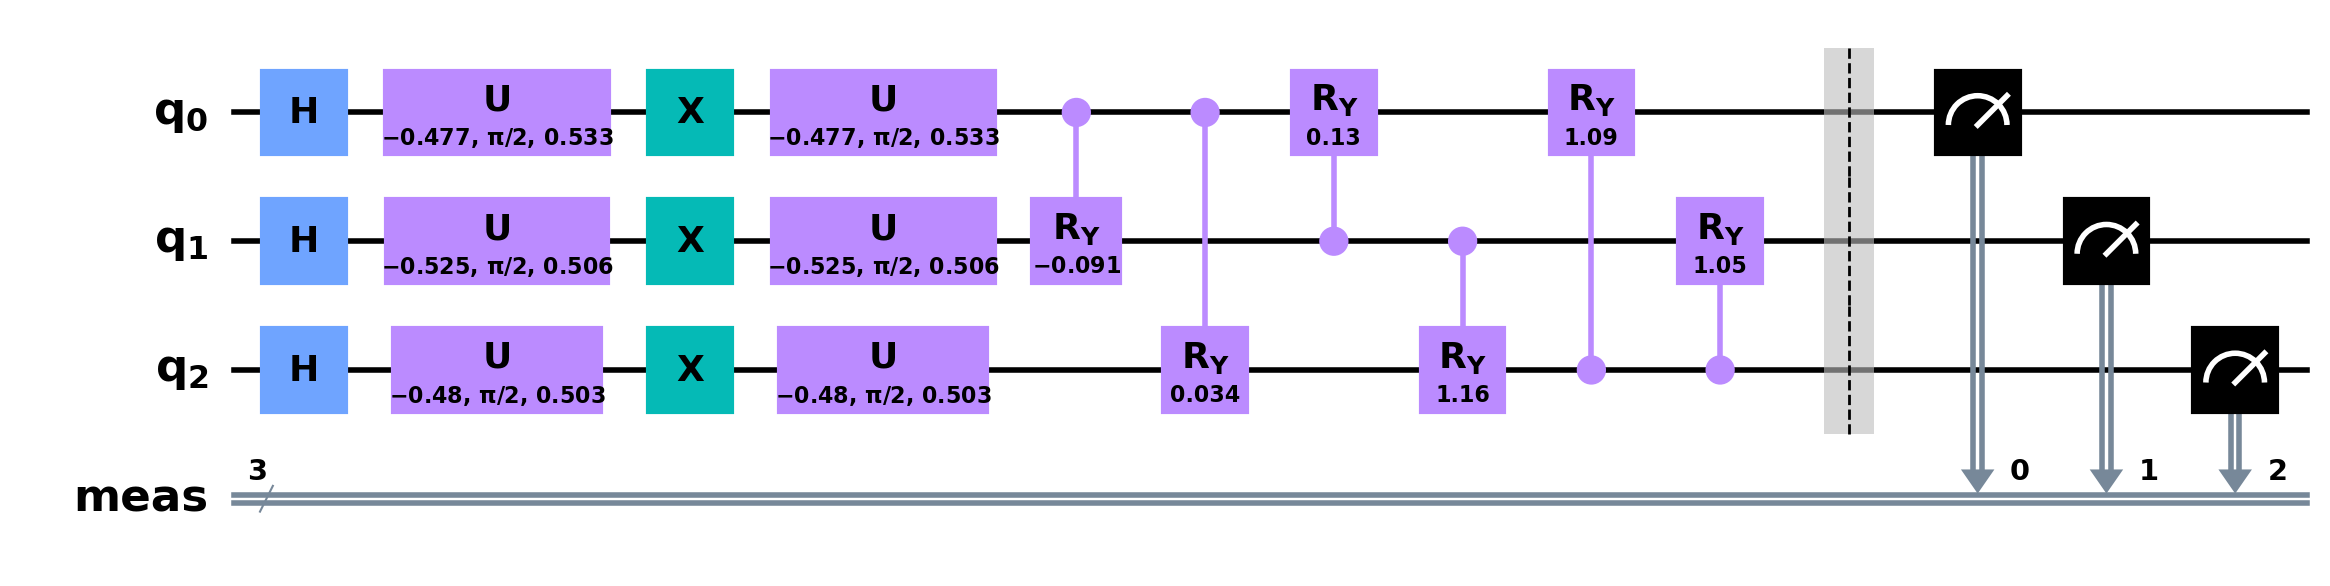

In [ ]:
num_qubits = cirq.num_qubits # Get number of qubits from the circuit
min_ones = 0
max_ones = 3
result_interaction_bfgs, optimized_full_params, cost_values = vqe_solver(
    histogram_data,
    cirq, # Renamed from 'cirquit' for common convention
    act_percentages, # Renamed from 'act_percentages' for consistency with create_parameter_dictionaries_cust
    cost_func_wrapper, # This function needs to be defined to accept the correct arguments (see comments below)
    min_ones_obs=min_ones, # Added as an explicit argument for flexibility
    max_ones_obs=max_ones,
    energy_map = 'neg_log_prob', # New parameter: 'linear_counts', 'log_counts', 'neg_log_prob'
    optimizer_method="COBYLA",# COBYLA | L-BFGS-B
)

# Plot the cost function values
plt.figure(figsize=(5, 4))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig('vqe_3qubit_opt.svg', bbox_inches='tight')
plt.show()
counts, bound_circuit = evaluate_and_plot_ansatz(cirq, optimized_full_params, shots=1024,  title="VQE optimization histogram", figsize=(5, 4), filename='hist_vqe_3qubit_opt.svg')
bound_circuit.draw(output="mpl", style="clifford", fold=40, scale=2.0, filename='circuit_vqe_3qubit_opt.svg')  # Show the circuit plot
